### EDA Notebook

- This notebook is for any EDA done in Python 

- Be sure to separate out the EDA tasks so your team doesn't get any merge conflicts 

- Use enough markdown of main takeaways and justification 

<br>

<div align='center'>

**For a streamlined EDA process amongst 3 teammates, we have subdivided this notebook into 3 sections, with each's own work contained within their dedicated section.**

</div>

> !NOTE
> Documentation on individual sections can be found attached to this folder.

In [17]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

***

# **Thierno**

***

***

# **Ro**

In [18]:
# connecting to db to query it

path = '/Users/Marcy_Student/Desktop/Marcy-Modules/CID/CID_data-slayer-corps/sql/CID_database_clean.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

### **Query for all statistical tests:**

In [69]:
# Our query for all statistical tests
query1 = """
SELECT borough, 
family_involvement_pct_positive, 
avg_student_attendance
FROM dim_location l
JOIN dim_environment e
ON e.DBN = l.DBN
"""

query2 = """
SELECT borough,
e.school_name,
metric_value_postsecondary_enrollment_6_months AS postsec_enroll_6mo, 
economic_need_index,
percent_temp_housing,
metric_value_4yr_ccr_all_students
FROM dim_location l
JOIN dim_environment e
ON e.DBN = l.DBN
JOIN fact_school_outcomes f
ON e.DBN = f.DBN
"""

df1 = pd.read_sql_query(query1, conn)
df2 = pd.read_sql_query(query2, conn)
display(df1)
display(df2)

,borough,family_involvement_pct_positive,avg_student_attendance
0,Manhattan,0.81,0.818
1,Manhattan,0.82,0.915
2,Manhattan,0.93,0.935
3,Manhattan,0.93,0.941
4,Manhattan,0.85,0.919
...,...,...,...
501,Bronx,NaN,0.869
502,Bronx,NaN,NaN
503,Bronx,NaN,0.826
504,Bronx,NaN,0.847


,borough,school_name,postsec_enroll_6mo,economic_need_index,percent_temp_housing,metric_value_4yr_ccr_all_students
0,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0
1,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0
2,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0
3,Manhattan,Orchard Collegiate Academy,0.707,0.911,0.190,54.0
4,Manhattan,University Neighborhood High School,0.839,0.719,0.097,77.1
...,...,...,...,...,...,...
2019,Bronx,Bronx Preparatory Charter School,0.722,0.912,0.097,NaN
2020,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN
2021,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN
2022,Bronx,KIPP Academy Charter School,0.673,0.853,0.104,NaN


## **Statistical Testing**

### Step 1: Loading Data, formatting and preprocessing

***

#### **Family Involvement <-> School Attendance**

family_involvement_pct_positive    54
avg_student_attendance             11
dtype: int64

array([[<Axes: title={'center': 'family_involvement_pct_positive'}>,
        <Axes: title={'center': 'avg_student_attendance'}>]], dtype=object)

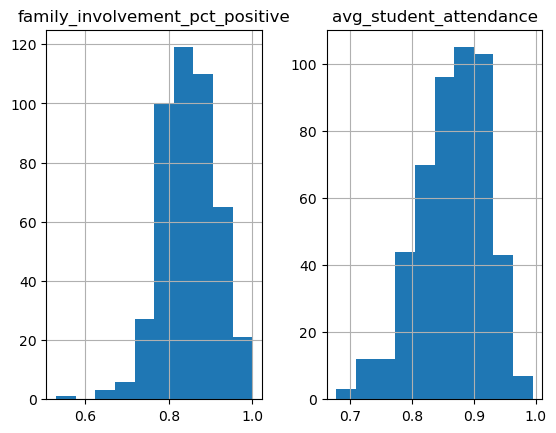

In [62]:
# checking for NAs + distribution
display(df1[['family_involvement_pct_positive', 'avg_student_attendance']].isna().sum())
display(df1.hist())

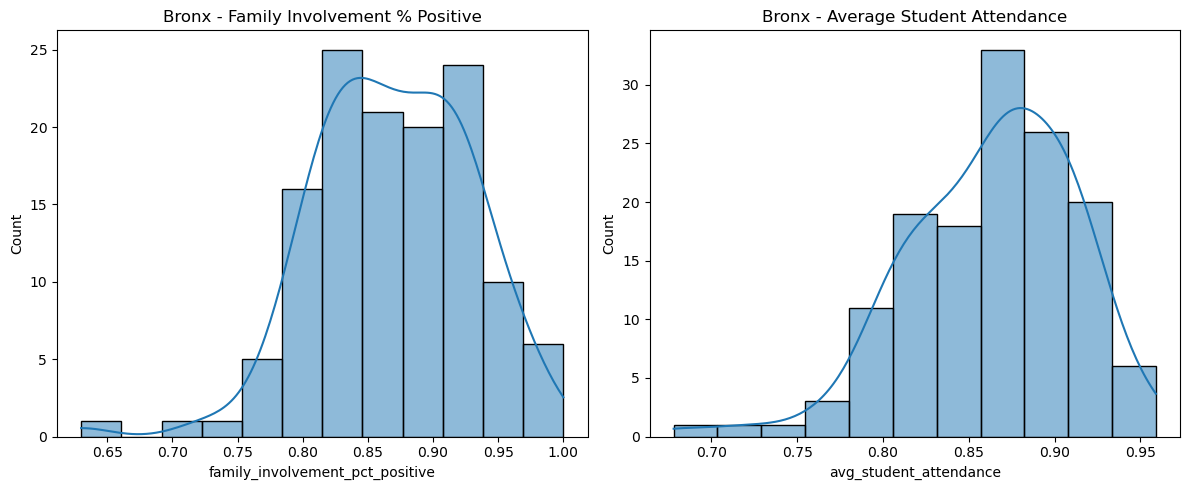

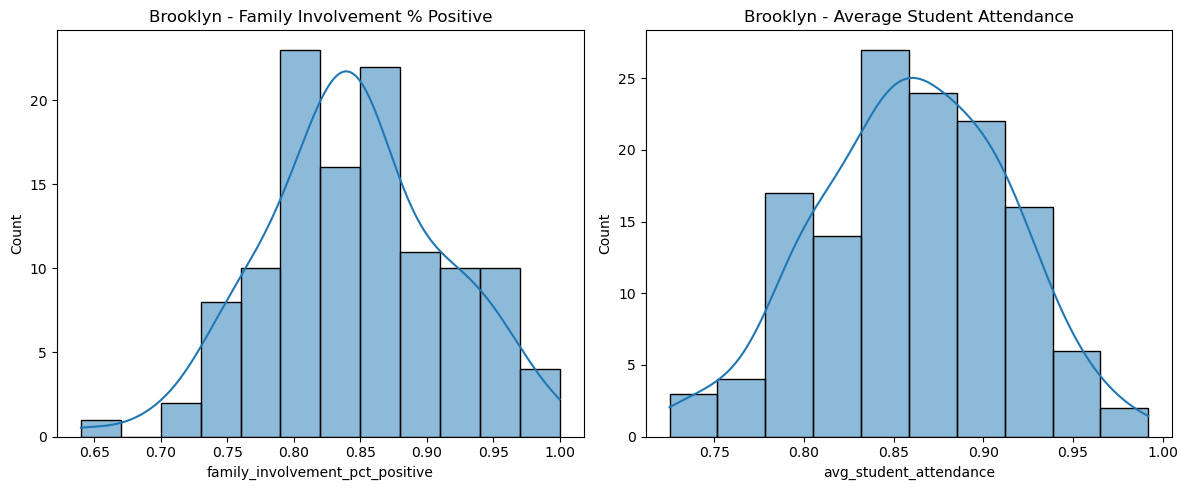

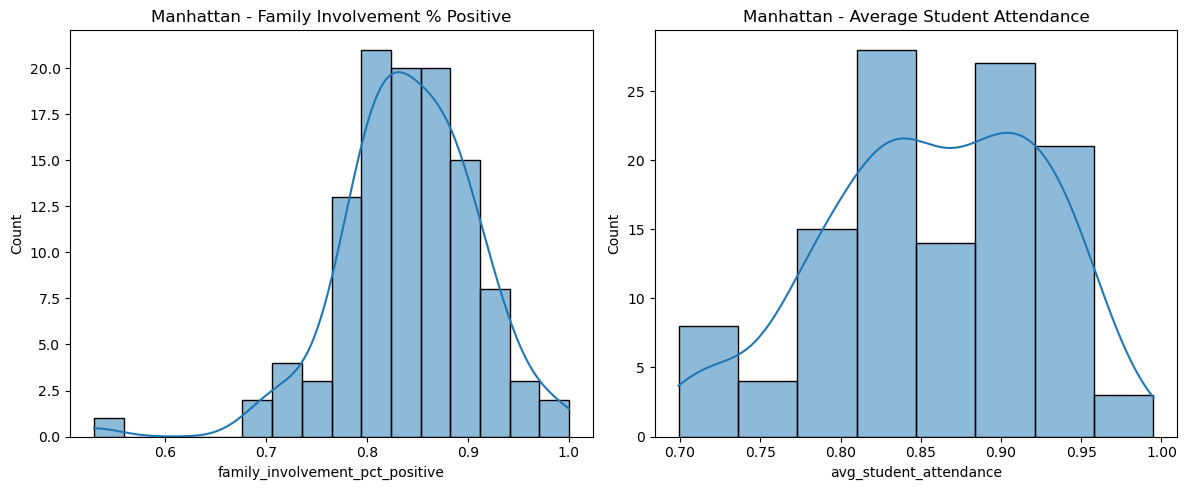

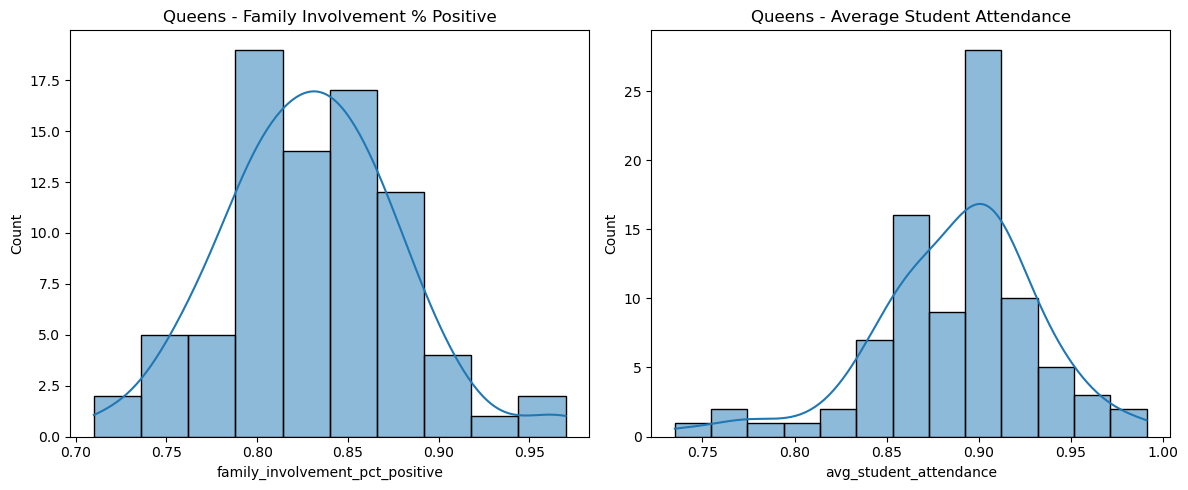

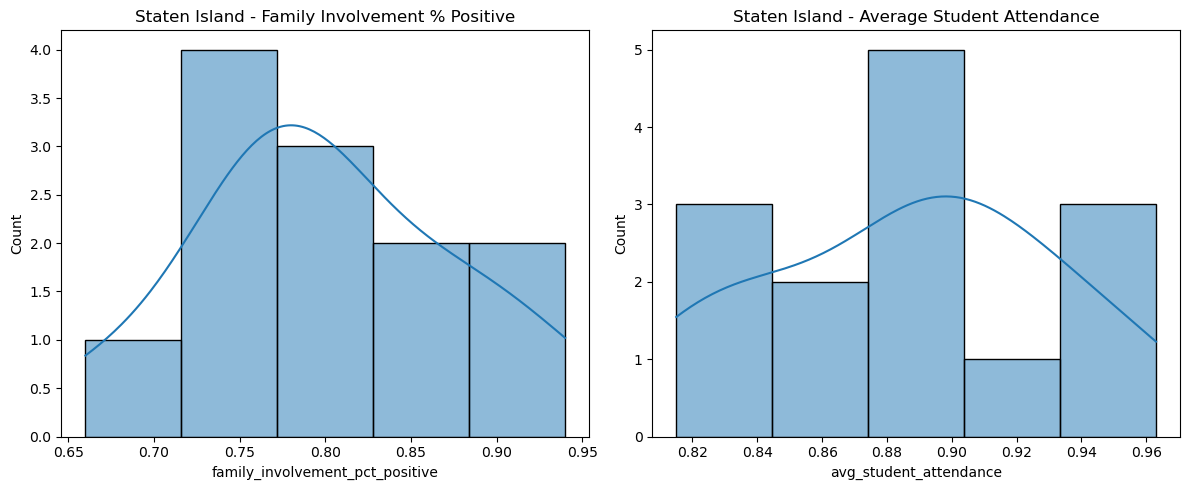

In [63]:
# also want histograms of the two variables per borough
borough = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
for b in borough:
    subset = df1[df1['borough'] == b]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(subset['family_involvement_pct_positive'], kde=True)
    plt.title(f'{b} - Family Involvement % Positive')
    plt.subplot(1, 2, 2)
    sns.histplot(subset['avg_student_attendance'], kde=True)
    plt.title(f'{b} - Average Student Attendance')
    plt.tight_layout()
    plt.show()

# Note: AI was used here only for plt formatting within the for loop.

In [64]:
# Imputing family involvement with borough means, and attendance with overall mean (since it is more normally distributed)
df_family_avg = df1.copy()
df_family_avg['family_involvement_pct_positive'] = df_family_avg.groupby('borough')['family_involvement_pct_positive'].transform(lambda x: x.fillna(x.mean()))

df_attendance_avg = df1.copy()
overall_attendance_mean = df_attendance_avg['avg_student_attendance'].mean()
df_attendance_avg['avg_student_attendance'] = df_attendance_avg['avg_student_attendance'].fillna(overall_attendance_mean)

# then, let's combine these two
df_filled = df_family_avg.merge(df_attendance_avg, how='inner')
df_filled.isna().sum()

borough                            0
family_involvement_pct_positive    0
avg_student_attendance             0
dtype: int64

array([[<Axes: title={'center': 'family_involvement_pct_positive'}>,
        <Axes: title={'center': 'avg_student_attendance'}>]], dtype=object)

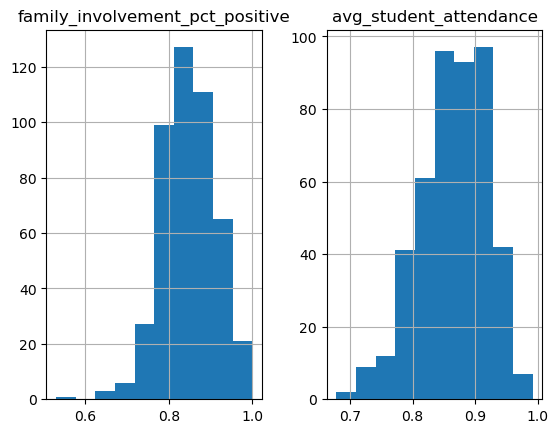

In [65]:
# quick look at distribution again with imputed values
df_filled.hist()

***



### Step 2: Conducting Test

In [25]:
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

***

### **Adjust Variables here**

In [ ]:
# Adjustable Variables

var_a = df_filled['family_involvement_pct_positive']
var_b = df_filled['avg_student_attendance']

***

#### **Welch's T-Test: family involvement and average student attendance**

H_0 = There is no statistically significant difference between family involvement and average student attendance.

H_1 = There is a statistically significant(ly)(greater, lesser) difference between family involvement and average student attendance.

In [43]:
# Welch's T-Test: Testing for left, right, and two-sided to see statistical significance.
alt1 = ['greater', 'less', 'two-sided']
for a in alt1:
    t_stat, p_val = stats.ttest_ind(var_a, var_b, equal_var=False, alternative=a)
    print(a)
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_val:.6f}")
    print('===================================')

greater
T-statistic: -4.743
P-value: 0.999999
less
T-statistic: -4.743
P-value: 0.000001
two-sided
T-statistic: -4.743
P-value: 0.000002


In [ ]:
#conduct ANOVA test
f_stat1, p_stat1 = f_oneway()
print(f'F-Statistic: {f_stat1}, P-Value: {p_stat1}')

***

***

# **Debo**

***